In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from statsmodels.sandbox.nonparametric.tests.ex_smoothers import weights
from statsmodels.tools import categorical
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold



In [119]:
# Load the data
df = pd.read_parquet('../data/processed/num_imputed_df.parquet')
df = df.dropna(subset=['target'])
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,target
0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,18.0,20.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,6.0,10.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,16.0,17.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,20.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,16.0,17.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# PCA

Creation of the training and test sets

In [120]:
x_train, x_test = train_test_split(df, test_size=0.2, random_state=42)

Standarization

In [121]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

PCA

In [122]:
pca = PCA(0.95)
pca.fit(x_train_scaled)
pca.n_components_

np.int64(70)

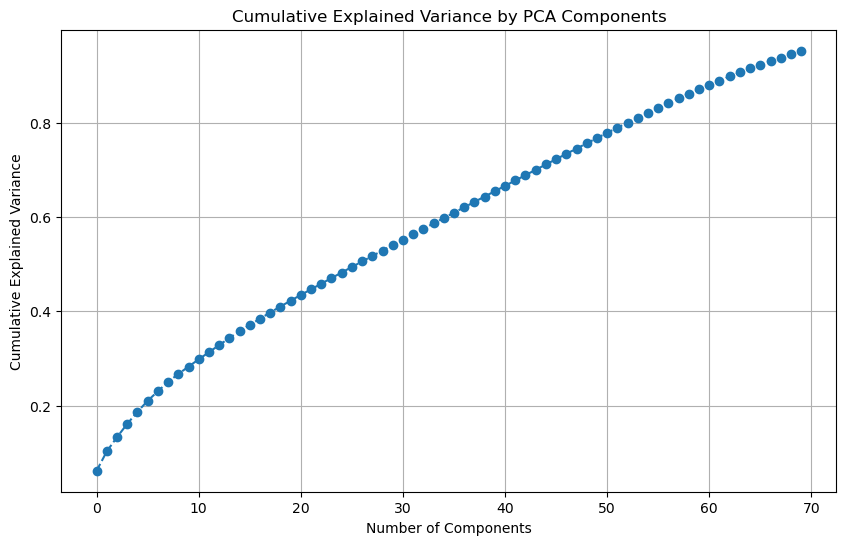

In [123]:
# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [124]:
x_train_pca = pca.transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Create df for PCA components
pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
x_train_pca_df = pd.DataFrame(x_train_pca, columns=pca_columns)
x_test_pca_df = pd.DataFrame(x_test_pca, columns=pca_columns)

print(x_train_pca_df.head())
print(x_test_pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.972850  2.047753  0.192628  0.804543 -0.484130 -1.964795 -2.331653   
1  3.018772  8.542826  0.292078 -0.423046 -0.942297  0.143949 -3.648729   
2  0.491079  1.446483  0.576990 -1.447457 -0.217986  0.837876 -1.818471   
3 -5.073356 -0.275989 -1.575879  0.343900  0.276357 -0.374197  0.263892   
4  1.908217  2.199077  1.578073 -1.648163  2.928288  0.668905  0.015668   

        PC8       PC9      PC10  ...      PC61      PC62      PC63      PC64  \
0 -0.643435  0.283132 -0.015596  ... -0.188455  0.354614 -0.211643  0.705364   
1 -0.432192 -2.664199 -1.737581  ...  3.375828 -2.190147  2.230800 -0.363362   
2  0.488842  1.089331  0.111650  ... -0.791517 -0.604513  0.433729  0.417786   
3 -0.544056 -1.352719  0.094597  ... -1.449113 -0.061588 -0.344299 -0.080663   
4  2.509623 -0.105521 -1.760116  ...  0.887090  0.420316 -0.232816  0.576885   

       PC65      PC66      PC67      PC68      PC69      PC70  
0  0

# Feature selection

Load the data

In [125]:
df = pd.read_parquet('../data/processed/imputed_df.parquet')
df = df.drop(['NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M'], axis=1)
df = df.dropna(subset=['target'])
df = df.reset_index(drop=True)
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,target,OCCUPATION_TYPE,CODE_GENDER,NAME_CONTRACT_TYPE
0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,18.0,20.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Laborers,M,Cash loans
1,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,6.0,10.0,Higher education,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Core staff,F,Cash loans
2,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,16.0,17.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Laborers,M,Revolving loans
3,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,20.0,16.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Laborers,F,Cash loans
4,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,16.0,17.0,Secondary / secondary special,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Core staff,M,Cash loans


In [126]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(exclude=['object', 'category']).columns

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False,drop='first')
encoded_categorical = encoder.fit_transform(df[categorical_cols])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))

df = pd.concat([encoded_categorical_df, df[numerical_cols]], axis=1)
df.head()

,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,target
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# Split the data
X = df.drop('target', axis=1)
y = df['target']

#### Variance Threshold

In [128]:
# Scale the features, using MinMaxScaler
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Calculate the variance of each feature
variances = scaled_X.var(axis=0)

# Sort the variances in descending order
sorted_indices = np.argsort(-variances)
sorted_variances = variances[sorted_indices]
sorted_columns = X.columns[sorted_indices]

# Print the sorted variances
for col, var in zip(sorted_columns, sorted_variances):
    print(f"{col}: {var}")

CODE_GENDER_M: 0.22492486558634323
FLAG_OWN_CAR: 0.22443326885953124
FLAG_OWN_REALTY: 0.21249143481673974
FLAG_DOCUMENT_3: 0.20588515206600805
NAME_EDUCATION_TYPE_Secondary / secondary special: 0.20581955632828286
FLAG_PHONE: 0.20206557090835445
NAME_EDUCATION_TYPE_Higher education: 0.18418108740814165
REG_CITY_NOT_WORK_CITY: 0.17734618744597047
FLAG_WORK_PHONE: 0.15961402985713147
FLAG_EMP_PHONE: 0.14767170836797158
LIVE_CITY_NOT_WORK_CITY: 0.14731562479842852
OCCUPATION_TYPE_Laborers: 0.14725725979012888
WEEKDAY_APPR_PROCESS_START_TUESDAY: 0.14455665582834543
WEEKDAY_APPR_PROCESS_START_WEDNESDAY: 0.1403657766660454
WEEKDAY_APPR_PROCESS_START_MONDAY: 0.1377205332738621
WEEKDAY_APPR_PROCESS_START_THURSDAY: 0.1374523108652192
DAYS_EMPLOYED: 0.1359526314477022
WEEKDAY_APPR_PROCESS_START_SATURDAY: 0.09796764254946433
OCCUPATION_TYPE_Sales staff: 0.0934972611404505
NAME_CONTRACT_TYPE_Revolving loans: 0.08613620806579042
OCCUPATION_TYPE_Core staff: 0.08161382776657544
FLAG_DOCUMENT_6: 0.080

Plotting the variance of the features

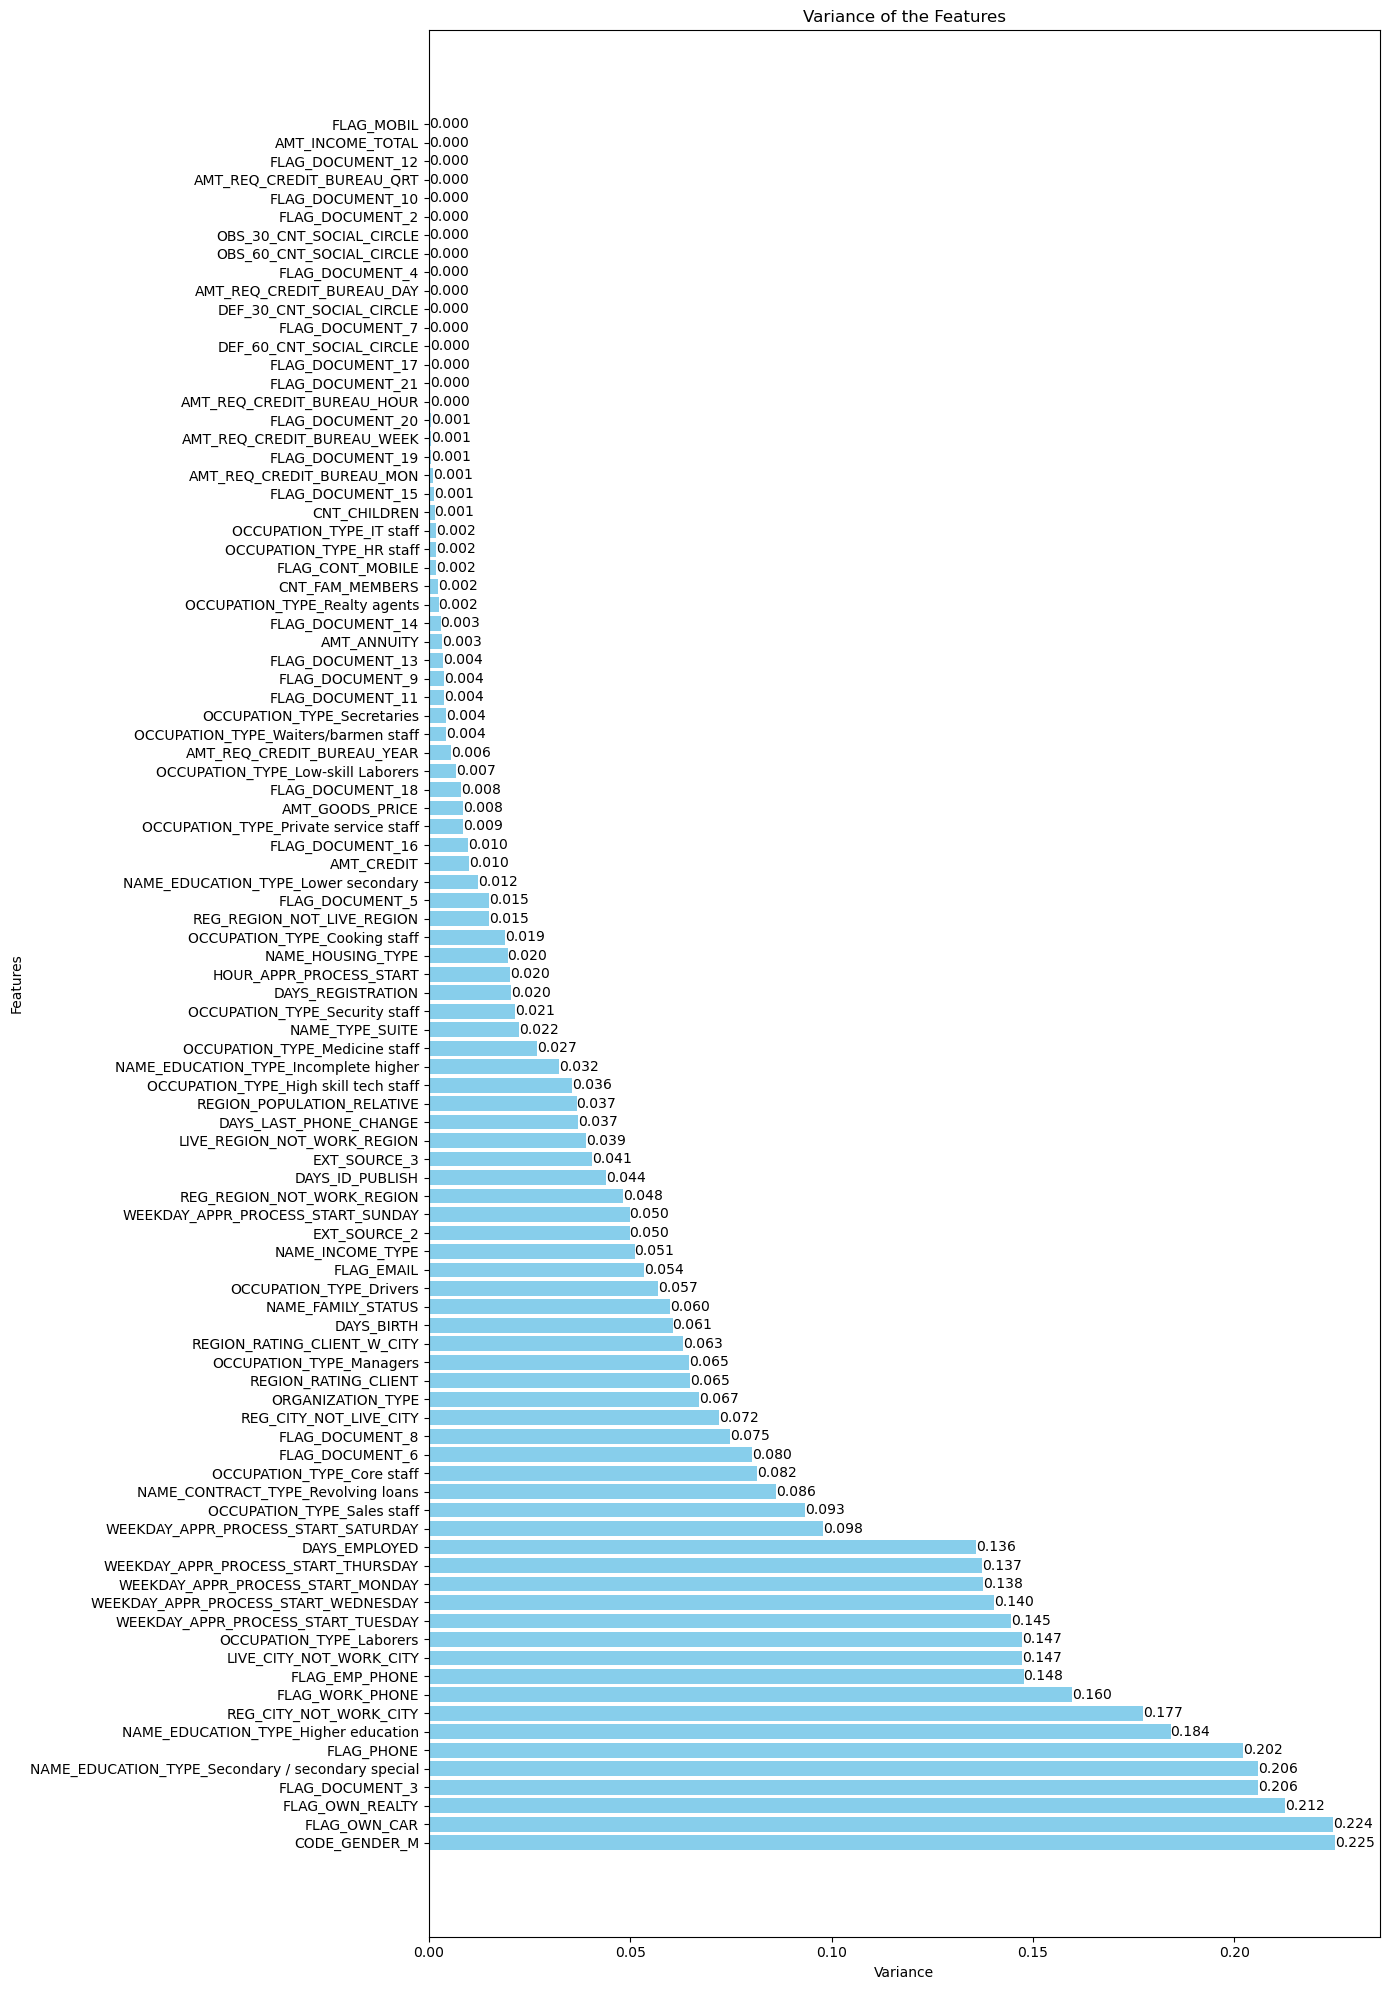

In [129]:
import matplotlib.pyplot as plt

top_variances = sorted_variances
top_columns = sorted_columns

plt.figure(figsize=(14, 20))  
bars = plt.barh(top_columns, top_variances, color='skyblue')  
plt.xlabel('Variance')
plt.ylabel('Features')
plt.title(f'Variance of the Features')

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.3f}', 
             va='center', ha='left', fontsize=10)

plt.tight_layout()  
plt.show()


We are going to select the features with a variance greater than 0.01

In [100]:
varianceSelector = VarianceThreshold(threshold=0.01)
varianceSelector.fit(scaled_X)

selected_features_mask = varianceSelector.get_support()

selected_features = X.columns[selected_features_mask]
discarded_features = X.columns[~selected_features_mask]

print(f"Selected features: {selected_features}")
print(f"Discarded features: {discarded_features}")
print(f"Number of selected features: {len(selected_features)}")
print(f"Number of discarded features: {len(discarded_features)}")

Selected features: Index(['NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'WEEKDAY_APPR_PROCESS_START_MONDAY',
       'WEEKDAY_APPR_PROCESS_START_SATURDAY',
       'WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'WEEKDAY_APPR_PROCESS_START_THURSDAY',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY',
       'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'OCCUPATION_TYPE_Cooking staff',
       'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine staff',
       'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Security staff',
       'CODE_GENDER_M', 'NAME_CONTRACT_TYPE_Revolving loans', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'AMT_CREDIT', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HO

In [101]:
X = X[selected_features]
X.head()

,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,...,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,209.0,0.262949,0.139376,-1134.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,74.0,0.622246,0.628502,-828.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,115.0,0.555912,0.729567,-815.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,208.0,0.650442,0.737596,-617.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,73.0,0.322738,0.518093,-1106.0,0.0,0.0,0.0,1.0


#### Recursive Feature Elimination (RFE)

Creation of the training and test sets

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [159]:
rfe_score = {}
rfe_features = {}

iterations = 0

for k in range(10,41,10):
    xgb = XGBClassifier(tree_method='hist', device = "cuda",random_state = 42, scale_pos_weight = 8)  # Configurado para usar GPU

    RFE_selector = RFE(xgb, n_features_to_select=k, step=1)
    RFE_selector.fit(X_train, y_train)

    
    sel_x_train = RFE_selector.transform(X_train)
    sel_x_test = RFE_selector.transform(X_test)
    
    xgb.fit(sel_x_train, y_train)
    RFE_preds = xgb.predict(sel_x_test)
    
    score = round(f1_score(y_test, RFE_preds), 5)
    rfe_score[k] = score
    rfe_features[k] = X_train.columns[RFE_selector.get_support()]
    iterations += 1
    print(f'Iteration {iterations} with {k} features: {score}')
    print(f'Selected features: {rfe_features[k]}')
    print("-"*50)

Iteration 1 with 10 features: 0.09041
Selected features: Index(['NAME_EDUCATION_TYPE_Secondary / secondary special',
       'OCCUPATION_TYPE_Drivers', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'ORGANIZATION_TYPE',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')
--------------------------------------------------
Iteration 2 with 20 features: 0.08268
Selected features: Index(['NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'OCCUPATION_TYPE_Drivers', 'CODE_GENDER_M', 'AMT_CREDIT',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object

Saving the results

In [162]:
X = X[['NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'WEEKDAY_APPR_PROCESS_START_SUNDAY',
       'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'OCCUPATION_TYPE_Core staff',
       'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_High skill tech staff',
       'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Sales staff',
       'CODE_GENDER_M', 'NAME_CONTRACT_TYPE_Revolving loans',
       'FLAG_OWN_REALTY', 'AMT_CREDIT', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_8']]

# Merge the target column
df = X.copy()
df['target'] = y

df.to_parquet('../data/processed/selected_features_df.parquet')

# Studying the results

In [148]:
unique_values, counts = np.unique(RFE_preds, return_counts=True)

# Mostrar los valores únicos y sus frecuencias
for value, count in zip(unique_values, counts):
    print(f"Valor: {value}, Frecuencia: {count}")

Valor: 0, Frecuencia: 56682
Valor: 1, Frecuencia: 4819


In [149]:
f1_score(y_test, RFE_preds, average='micro')

np.float64(0.8536771759808783)

In [150]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, RFE_preds).ravel()

# Sensibilidad (Recall)
sensitivity = tp / (tp + fn)

# Especificidad (True Negative Rate)
specificity = tn / (tn + fp)

print(f"Sensibility: {sensitivity}")
print(f"Specificity: {specificity}")


Sensibility: 0.08630245447347586
Specificity: 0.9223546918457368


Confusion Matrix

In [151]:
confusion_matrix(y_test, RFE_preds)

array([[52066,  4383],
       [ 4616,   436]])

In [135]:
df['target'].value_counts()

target
0.0    282679
1.0     24824
Name: count, dtype: int64

In [146]:
y_test.value_counts()

target
0.0    56449
1.0     5052
Name: count, dtype: int64

The model is not predicting the minority class, which is the target class. We need to treat this problem when we create the models.